# Earthquake Prediction

#### Table of Contents
0. Setup
1. Data Analysis
2. Data Preparation
3. Model Training
4. Model Evaluation

In [18]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import catboost as cb
from sklearn import preprocessing, model_selection, linear_model
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

## 0. Setup

In [19]:
filepath = './data/earthquakes.csv'

## 1. Data Analysis

In [20]:
df = pd.read_csv(filepath)
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2022-10-06 13:10:10.910000+00:00,33.972833,-116.675000,14.33,0.69,ml,15.0,79.0,0.06927,0.20,...,2022-10-06T13:13:49.222Z,"12km SW of Morongo Valley, CA",earthquake,0.47,1.01,0.196,17.0,automatic,ci,ci
1,2022-10-06 13:10:10.910000+00:00,33.972833,-116.675000,14.33,0.69,ml,15.0,79.0,0.06927,0.20,...,2022-10-06T13:13:49.222Z,"12km SW of Morongo Valley, CA",earthquake,0.47,1.01,0.196,17.0,automatic,ci,ci
2,2022-10-06 13:05:24.316000+00:00,59.726700,-152.436100,70.00,1.40,ml,NaN,NaN,NaN,0.30,...,2022-10-06T13:06:46.715Z,"34 km W of Anchor Point, Alaska",earthquake,NaN,2.30,NaN,NaN,automatic,ak,ak
3,2022-10-06 13:05:24.316000+00:00,59.726700,-152.436100,70.00,1.40,ml,NaN,NaN,NaN,0.30,...,2022-10-06T13:06:46.715Z,"34 km W of Anchor Point, Alaska",earthquake,NaN,2.30,NaN,NaN,automatic,ak,ak
4,2022-10-06 13:04:54+00:00,38.834999,-122.784332,1.89,1.02,md,17.0,66.0,0.00580,0.02,...,2022-10-06T13:06:28.843Z,"6km WNW of Cobb, CA",earthquake,0.23,0.39,0.360,3.0,automatic,nc,nc


In [21]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,35245.000000,35245.000000,35245.000000,35244.000000,28039.000000,29242.000000,24219.000000,35245.000000,24990.000000,35245.000000,26445.000000,27361.000000
mean,37.167296,-108.587333,21.477970,1.663011,23.384821,116.449267,0.816615,0.275335,1.929262,4.240555,0.252210,17.163664
std,19.093452,67.751199,54.360028,1.311471,21.687507,60.421071,2.755243,0.272876,3.300828,389.379273,0.461743,34.172450
min,-65.352200,-179.996400,-3.730000,-1.430000,0.000000,11.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
25%,33.420500,-149.703200,3.600000,0.800000,10.000000,71.000000,0.025000,0.100000,0.280000,0.470000,0.103000,5.000000
50%,38.151200,-118.777667,8.000000,1.340000,17.000000,102.000000,0.059570,0.160000,0.480000,0.800000,0.160000,9.000000
75%,47.511900,-113.778167,14.560000,2.110000,29.000000,150.000000,0.165750,0.400000,1.090000,1.780000,0.236000,18.000000
max,87.349200,180.000000,647.998000,7.800000,444.000000,355.000000,43.236000,2.460000,26.400000,73091.100000,5.520000,760.000000


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35245 entries, 0 to 35244
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             35245 non-null  object 
 1   latitude         35245 non-null  float64
 2   longitude        35245 non-null  float64
 3   depth            35245 non-null  float64
 4   mag              35244 non-null  float64
 5   magType          35244 non-null  object 
 6   nst              28039 non-null  float64
 7   gap              29242 non-null  float64
 8   dmin             24219 non-null  float64
 9   rms              35245 non-null  float64
 10  net              35245 non-null  object 
 11  id               35245 non-null  object 
 12  updated          35245 non-null  object 
 13  place            34456 non-null  object 
 14  type             35245 non-null  object 
 15  horizontalError  24990 non-null  float64
 16  depthError       35245 non-null  float64
 17  magError    

In [23]:
df.isnull().sum()

time                   0
latitude               0
longitude              0
depth                  0
mag                    1
magType                1
nst                 7206
gap                 6003
dmin               11026
rms                    0
net                    0
id                     0
updated                0
place                789
type                   0
horizontalError    10255
depthError             0
magError            8800
magNst              7884
status                 0
locationSource         0
magSource              0
dtype: int64

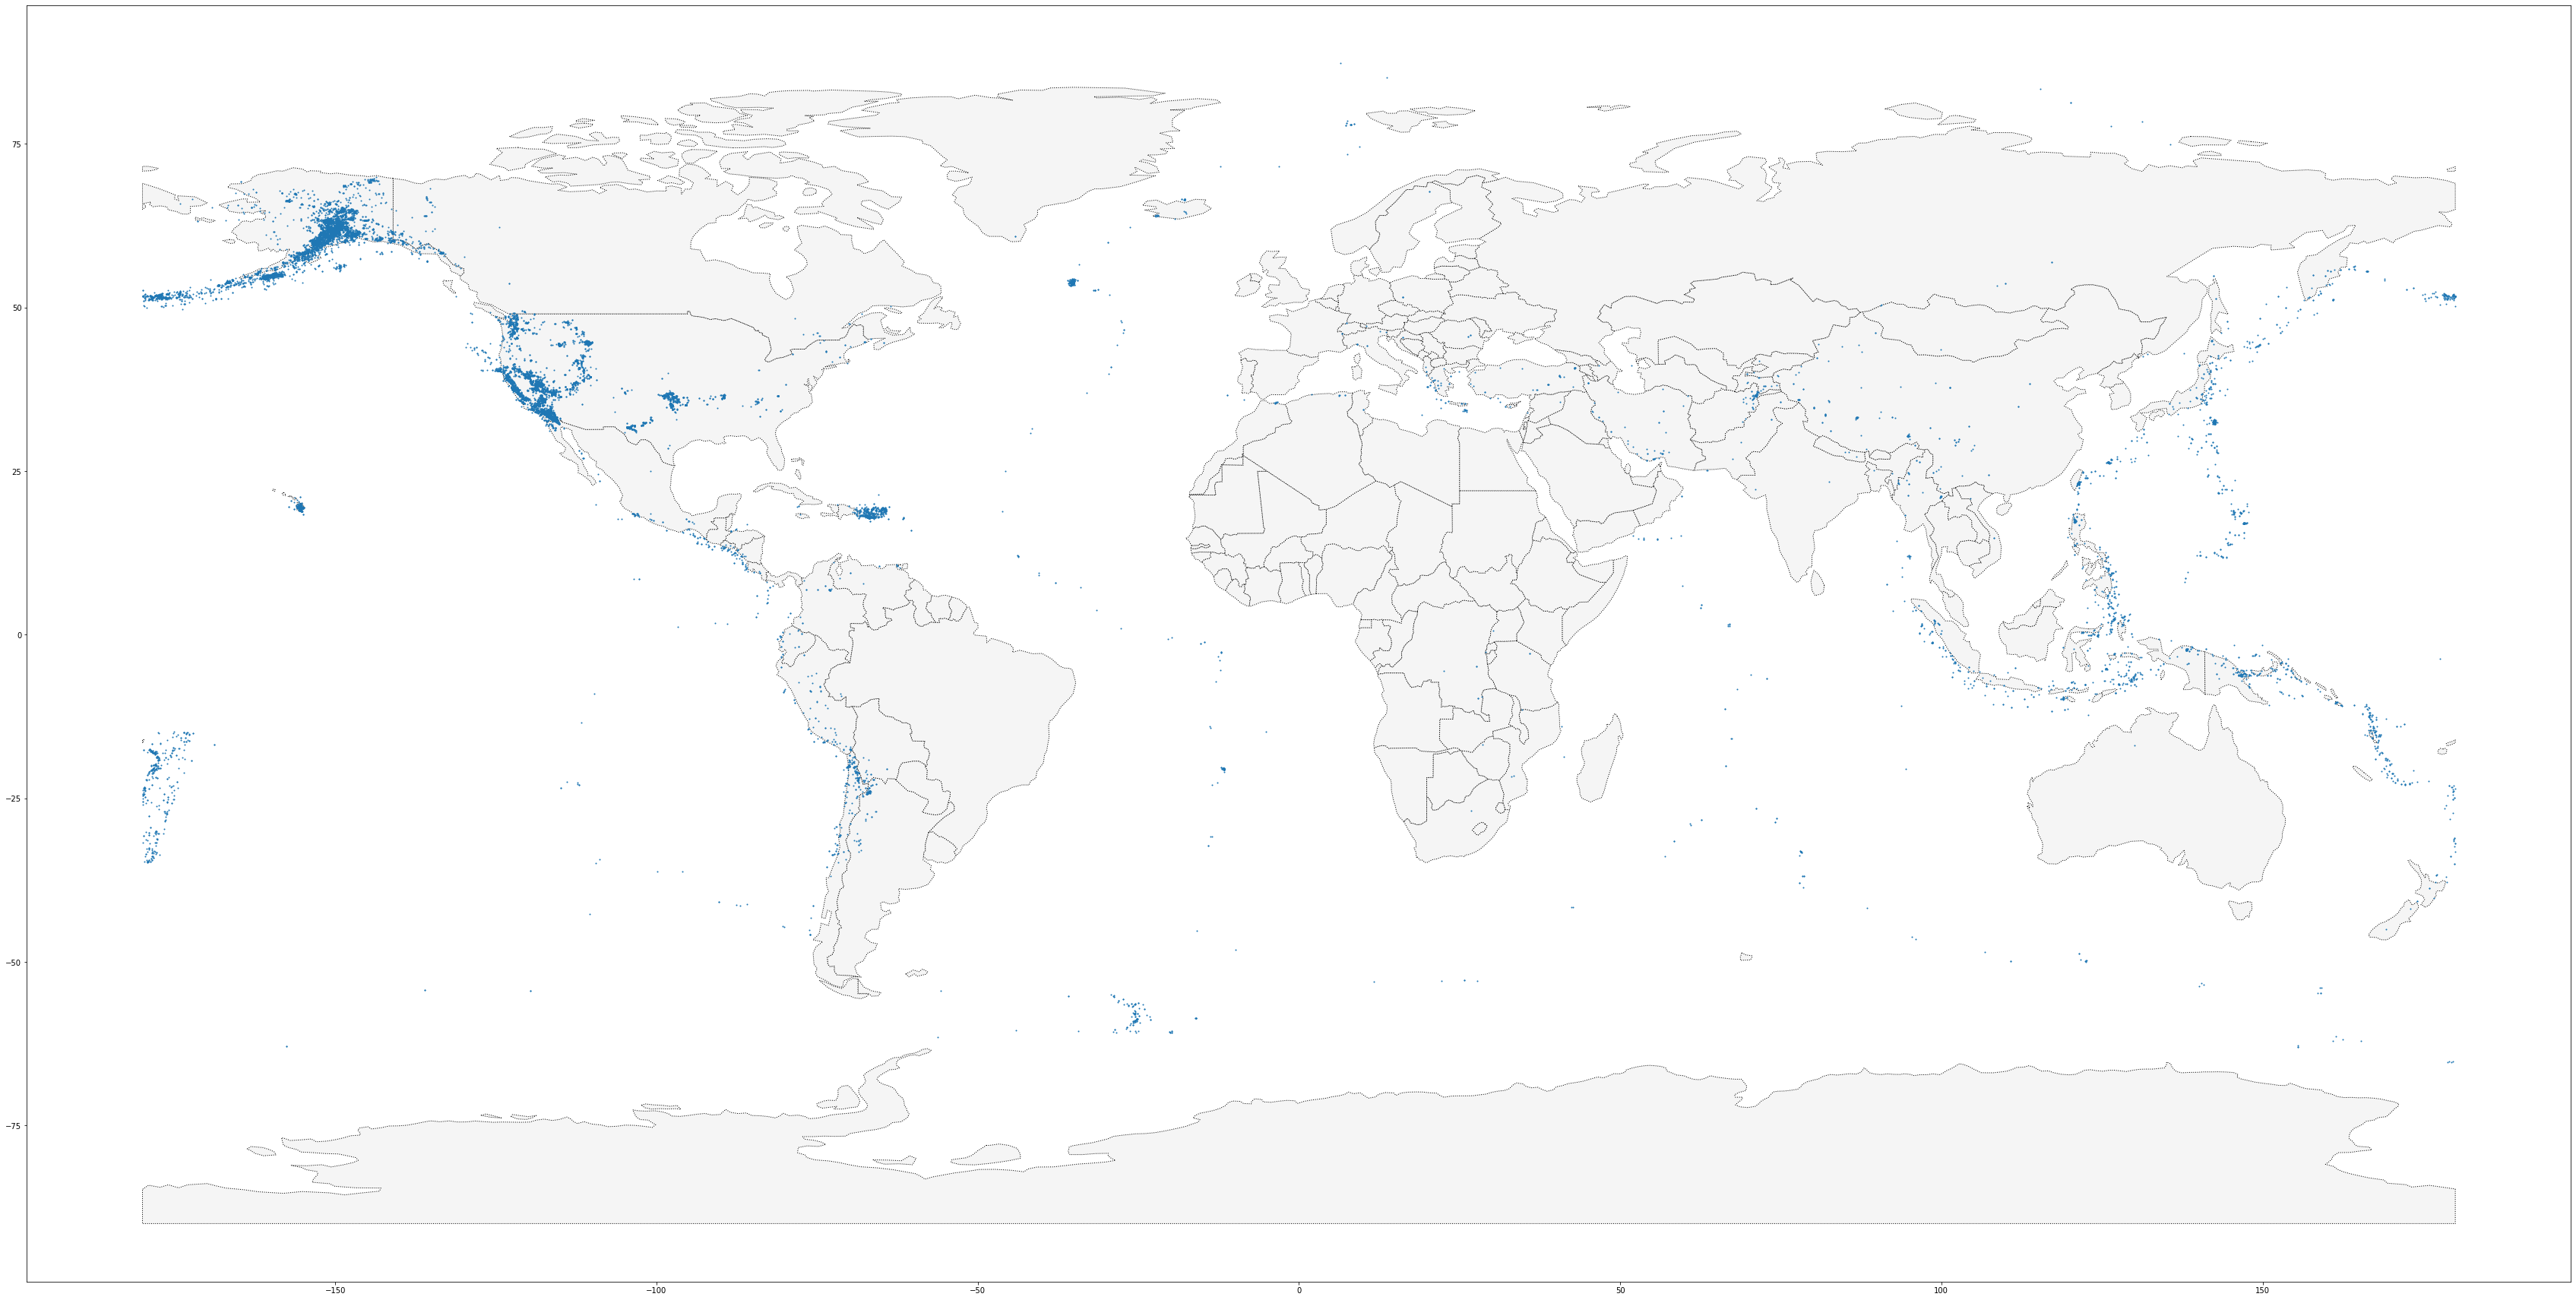

In [24]:
earthquakes = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitude'], df['latitude']))
earthquakes.crs = 'EPSG:4326'

world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)

ax = world.plot(figsize=(60, 60), color='whitesmoke', linestyle=':', edgecolor='black')
earthquakes.to_crs(epsg=4326).plot(markersize=1, ax=ax)
plt.show()

In [25]:
print(f'Min magnitude: {df["mag"].min()}')
print(f'Max magnitude: {df["mag"].max()}')

Min magnitude: -1.43
Max magnitude: 7.8


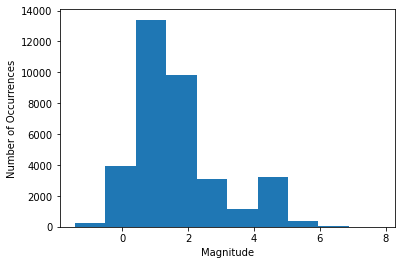

In [26]:
plt.hist(df['mag'])
plt.xlabel('Magnitude')
plt.ylabel('Number of Occurrences')
plt.show()

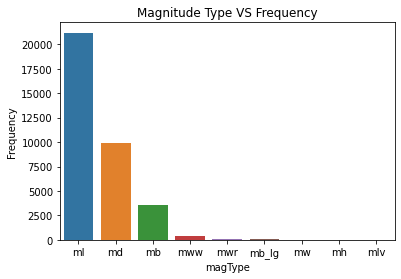

local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)


In [27]:
sns.countplot(data=df, x='magType')
plt.ylabel('Frequency')
plt.title('Magnitude Type VS Frequency')
plt.show()

print('local magnitude (ML), surface-wave magnitude (Ms), body-wave magnitude (Mb), moment magnitude (Mw)')

In [28]:
df.loc[df['mag'] >= 8, 'Class'] = 'Disastrous'
df.loc[(df['mag'] >= 7) & (df['mag'] < 7.9), 'Class'] = 'Major'
df.loc[(df['mag'] >= 6) & (df['mag'] < 6.9), 'Class'] = 'Strong'
df.loc[(df['mag'] >= 5.5) & (df['mag'] < 5.9), 'Class'] = 'Moderate'

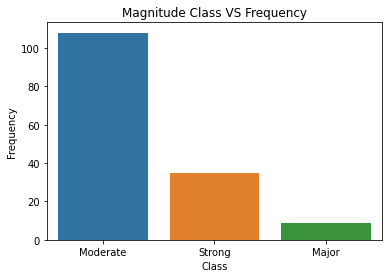

In [29]:
sns.countplot(data=df, x='Class')
plt.ylabel('Frequency')
plt.title('Magnitude Class VS Frequency')
plt.show()

## 2. Data Preparation

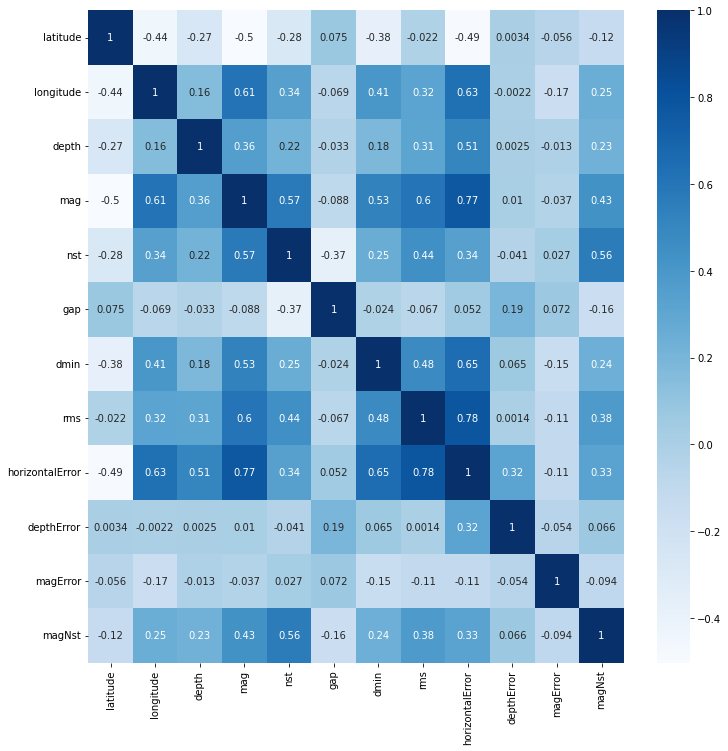

In [30]:
corr_matrix = df.corr() 
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.show()

In [31]:
threshold = 0.9
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
df.drop(to_drop, axis=1, inplace=True)

In [32]:
for column in df.columns:
    if df[column].isna().mean() > 0.3:
        df.drop(column, axis=1, inplace=True) 

In [34]:
scaler = MinMaxScaler()

columns = ['nst', 'gap']
df[columns] = scaler.fit_transform(df[columns])

df.describe()

,latitude,longitude,depth,mag,nst,gap,rms,horizontalError,depthError,magError,magNst
count,35245.000000,35245.000000,35245.000000,35244.000000,28039.000000,29242.000000,35245.000000,24990.000000,35245.000000,26445.000000,27361.000000
mean,37.167296,-108.587333,21.477970,1.663011,0.052669,0.306539,0.275335,1.929262,4.240555,0.252210,17.163664
std,19.093452,67.751199,54.360028,1.311471,0.048846,0.175643,0.272876,3.300828,389.379273,0.461743,34.172450
min,-65.352200,-179.996400,-3.730000,-1.430000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
25%,33.420500,-149.703200,3.600000,0.800000,0.022523,0.174419,0.100000,0.280000,0.470000,0.103000,5.000000
50%,38.151200,-118.777667,8.000000,1.340000,0.038288,0.264535,0.160000,0.480000,0.800000,0.160000,9.000000
75%,47.511900,-113.778167,14.560000,2.110000,0.065315,0.404070,0.400000,1.090000,1.780000,0.236000,18.000000
max,87.349200,180.000000,647.998000,7.800000,1.000000,1.000000,2.460000,26.400000,73091.100000,5.520000,760.000000


## 3. Model Training

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35245 entries, 0 to 35244
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   time             35245 non-null  object  
 1   latitude         35245 non-null  float64 
 2   longitude        35245 non-null  float64 
 3   depth            35245 non-null  float64 
 4   mag              35244 non-null  float64 
 5   magType          35244 non-null  object  
 6   nst              28039 non-null  float64 
 7   gap              29242 non-null  float64 
 8   rms              35245 non-null  float64 
 9   net              35245 non-null  object  
 10  id               35245 non-null  object  
 11  updated          35245 non-null  object  
 12  place            34456 non-null  object  
 13  type             35245 non-null  object  
 14  horizontalError  24990 non-null  float64 
 15  depthError       35245 non-null  float64 
 16  magError         26445 non-null  float64

In [38]:
features = ['latitude', 'longitude', 'nst', 'gap']
cat_features = ['place', 'net', 'status']
target = 'mag'

In [39]:
test = math.floor(len(df) * 0.25)

df.dropna(axis=0, inplace=True)

df_train = df.iloc[test:]
df_train = df_train[features + cat_features + [target]]

df_test = df.iloc[:test]
df_test = df_test[['time'] + features + cat_features + [target]]

In [40]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(
    df_train[features + cat_features],
    df_train[target], 
    test_size=0.2, 
    random_state=42,
)

In [41]:
grid = {
    'depth': [3, 5, 6],
    'learning_rate': [0.05, 0.1, 0.01],
    'iterations': [1000],
}

model = cb.CatBoostRegressor(
    early_stopping_rounds=10,
    cat_features=cat_features, 
)

grid_search_result = model.grid_search(
    grid, 
    x_train, 
    y_train,
    plot=True,
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0573410	test: 2.0793012	best: 2.0793012 (0)	total: 77ms	remaining: 1m 16s
1:	learn: 1.9657166	test: 1.9871124	best: 1.9871124 (1)	total: 86ms	remaining: 42.9s
2:	learn: 1.8792202	test: 1.9005597	best: 1.9005597 (2)	total: 91.1ms	remaining: 30.3s
3:	learn: 1.7975541	test: 1.8184297	best: 1.8184297 (3)	total: 96.9ms	remaining: 24.1s
4:	learn: 1.7198002	test: 1.7408396	best: 1.7408396 (4)	total: 102ms	remaining: 20.3s
5:	learn: 1.6463533	test: 1.6662076	best: 1.6662076 (5)	total: 106ms	remaining: 17.5s
6:	learn: 1.5770623	test: 1.5968417	best: 1.5968417 (6)	total: 110ms	remaining: 15.6s
7:	learn: 1.5127769	test: 1.5316203	best: 1.5316203 (7)	total: 118ms	remaining: 14.6s
8:	learn: 1.4518477	test: 1.4704504	best: 1.4704504 (8)	total: 124ms	remaining: 13.6s
9:	learn: 1.3940618	test: 1.4123186	best: 1.4123186 (9)	total: 130ms	remaining: 12.8s
10:	learn: 1.3381195	test: 1.3569167	best: 1.3569167 (10)	total: 135ms	remaining: 12.1s
11:	learn: 1.2858641	test: 1.3040292	best: 1.304029

In [42]:
grid_search_result['params']

{'depth': 6, 'iterations': 1000, 'learning_rate': 0.1}

In [43]:
predictions = model.predict(x_test)
print(f'Accuracy of Model: {model.score(x_test, y_test)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, predictions)}')

Accuracy of Model: 0.9526712616687742
Mean Absolute Error: 0.22254773046028017


Accuracy of Model: 0.935795005078089
Mean Absolute Error: 0.2725141999006533


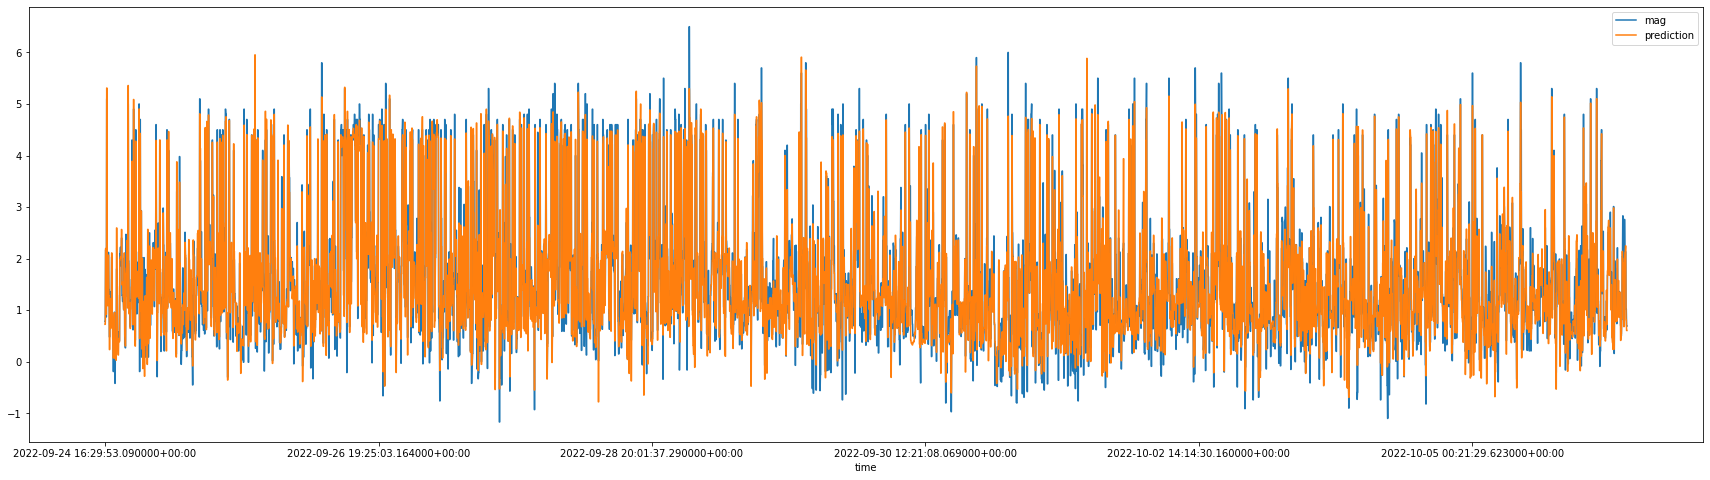

In [44]:
predictions = model.predict(df_test[features + cat_features])
print(f'Accuracy of Model: {model.score(df_test[features + cat_features], df_test[target])}')
print(f'Mean Absolute Error: {mean_absolute_error(df_test[target], predictions)}')

df_plot = pd.DataFrame({'time': df_test['time'], 'mag': df_test[target], 'prediction': predictions})
df_plot = df_plot[::-1]
df_plot.plot(x='time', figsize=(30, 8))
plt.show()

In [47]:
# model.save_model('../app/server/app/ml/model')